## Importing libraries and files

In [1]:
import pandas as pd
from keras.models import load_model
import pickle
import numpy as np
import matplotlib.pyplot as plt


ann_arr = load_model('IP_Arrival_time/Arrival_ANN_1')
ann_end = load_model('IP_End_time/End_ANN_2')
ann_chg = load_model('IP_Change_time/Change_ANN_3')

#Section1
ann1 = load_model('IP_Section_1_new/Section1_ANN_3')
sc1 = pickle.load(open('IP_Section_1_new/Section1_scaler_ANN_3.pkl', 'rb'))
#Section2
ann2 = load_model('IP_Section_2_new/Section2_new_ANN_5')
sc2 = pickle.load(open('IP_Section_2_new/Section2_new_scaler_ANN_5.pkl', 'rb'))
#Section3
ann3 = load_model('IP_Section_3_new/Section3_new_ANN_1')
sc3 = pickle.load(open('IP_Section_3_new/Section3_new_scaler_ANN_1.pkl', 'rb'))
#Section4
ann4 = load_model('IP_Section_4_new/Section4_new_ANN_1')
sc4 = pickle.load(open('IP_Section_4_new/Section4_new_scaler_ANN_1.pkl', 'rb'))
#Section5
ann5 = load_model('IP_Section_5_new/Section5_new_ANN_1')
sc5 = pickle.load(open('IP_Section_5_new/Section5_new_scaler_ANN_1.pkl', 'rb'))
#Section6
ann6 = load_model('IP_Section_6_new/Section6_new_ANN_1')
sc6 = pickle.load(open('IP_Section_6_new/Section6_new_scaler_ANN_1.pkl', 'rb'))

ModuleNotFoundError: No module named 'tensorflow'

## Input details

In [2]:
charge_mass = 16.2
standoff_distance = 2.2
termination_time = 50
interval = 0.01

## Pressure Profile

In [3]:
arr = np.array ([[charge_mass,standoff_distance]])

arrival_time = ann_arr.predict(arr)
end_time = ann_end.predict(arr)
change_time = ann_chg.predict(arr)
print ("end", end_time, "change", change_time)

def stable_state(start, end, interval):    
    t = np.arange(start, end + interval, interval)
    t = t.reshape(len(t),1)

    p = np.repeat(0, len(t)).reshape(len(t),1)
    
    values = np.concatenate ((t, p), axis = 1)
    return values

def p_fluctuation(standoff_distance, d_set):
    if 1.5 <= standoff_distance <= 3:
        d_set[:,0:3] = sc1.transform(d_set[:,0:3])
        p_f = ann1.predict(d_set)
        
    elif 3 < standoff_distance <= 7:
        d_set[:,0:3] = sc2.transform(d_set[:,0:3])
        p_f = ann2.predict(d_set)
        
    elif 7 < standoff_distance <= 13:
        d_set[:,0:3] = sc3.transform(d_set[:,0:3])
        p_f = ann3.predict(d_set)
        
    elif 13 < standoff_distance <= 19:
        d_set[:,0:3] = sc4.transform(d_set[:,0:3])
        p_f = ann4.predict(d_set)
        
    elif 19 < standoff_distance <= 25:
        d_set[:,0:3] = sc5.transform(d_set[:,0:3])
        p_f = ann5.predict(d_set)
        
    elif 25 < standoff_distance <= 30:
        d_set[:,0:3] = sc6.transform(d_set[:,0:3])
        p_f = ann6.predict(d_set)
        
    else:
        print ("Out of trained range")
    return p_f

if termination_time < arrival_time:
    start = 0
    end = termination_time
    values1 = stable_state(start, end, interval)
    arrival_time = 0
    end_time = 0

else:
    start = 0
    end = arrival_time
    values1 = stable_state(start, end, interval)
    
    if termination_time < end_time:
        end_time = termination_time
        
    else:
        start = end_time
        end = termination_time
        values3 = stable_state(start, end, interval)

t2= np.arange(arrival_time, end_time + interval, interval)
t2 = t2.reshape(len(t2),1)

if t2[0] < change_time:
    ph2 = np.array([[0, 1]])
else:
    ph2 = np.array([[1, 0]])
    
positive = np.array([0, 1])
negative = np.array([1, 0])

for time in t2[1:]:
    if time < change_time:
        ph2=np.vstack((ph2,positive))
    else:
        ph2=np.vstack((ph2,negative))
        
m2 = np.repeat(charge_mass, len(t2)).reshape(len(t2),1)
d2 = np.repeat(standoff_distance, len(t2)).reshape(len(t2),1)
d_set = np.concatenate ((m2, d2, t2, ph2), axis = 1)

p2 = p_fluctuation(standoff_distance, d_set)
p2 = p2.reshape((-1, 1))
values2 = np.concatenate ((t2, p2), axis = 1)


if 'values2' in globals():
    ml_model = np.concatenate((values1, values2), axis=0)
    if 'values3' in globals():
        ml_model = np.concatenate((ml_model, values3), axis=0)
else:
    ml_model = values1

1/1 [==============================] - 0s 197ms/step
end [[41.680073]] change [[10.399284]]


C:\Users\z5379606\AppData\Local\Temp\ipykernel_51980\3455498280.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t = np.arange(start, end + interval, interval)
C:\Users\z5379606\AppData\Local\Temp\ipykernel_51980\3455498280.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2= np.arange(arrival_time, end_time + interval, interval)


111/111 [==============================] - 1s 11ms/step


In [4]:
file_path = f'IP_Num&ANN_Comparison/LSDYNA/16.2kg/{standoff_distance}m.xlsx'
lsdyna = pd.read_excel(file_path)
X2 = lsdyna['Time']
y2 = lsdyna['Pressure']
X2=X2*1000
y2=(y2/1000)-101.2

X1 = ml_model[:,0]
y1 = ml_model[:,1]
#X1 = X1*1000
#y1 = y1/1000
print (standoff_distance)
print ("ML max", max(y1))
print ("LSDYNA max", max(y2))

5.7
ML max 138.25526428222656
LSDYNA max 125.778


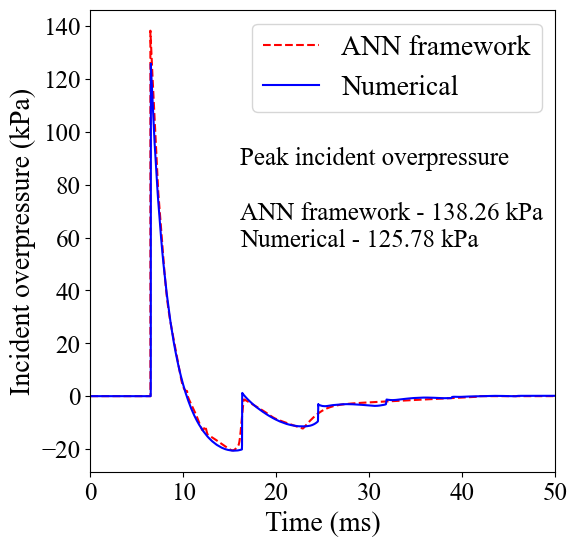

In [9]:
X1 = ml_model[:,0]
y1 = ml_model[:,1]

plt.figure(figsize=(6,6))
plt.rcParams["font.family"] = "Times New Roman"
plt.plot(X1, y1, linestyle = 'dashed', color = 'red', label = 'ANN framework')
plt.plot(X2, y2, color = 'blue',label = 'Numerical')
plt.ylabel('Incident overpressure (kPa)',fontsize = 20)
plt.xlabel('Time (ms)',fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 20)

# Create the annotation text
annotation_text = (f'Peak incident overpressure\n\nANN framework - {round(max(y1), 2)} kPa\n'
                   f'Numerical - {round(max(y2), 2)} kPa')

plt.annotate(annotation_text,xy=(0.4,0.5), xycoords='figure fraction', fontsize=18)

plt.xlim (0,termination_time)
plt.savefig('IP_Num&ANN_Comparison/Images2/Section2_5.7m/16.2kg.png', dpi=150, bbox_inches='tight')
plt.show()